# Image Denoising

In [1]:
from h5py import File as h5pyFile

with h5pyFile("data/assignmentImageDenoising_chestCT.mat", "r") as file:
    image_raw = file["imageChestCT"][:]

import numpy as np

image = np.array(image_raw).astype(np.float32)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(512, 512), dtype=float32)

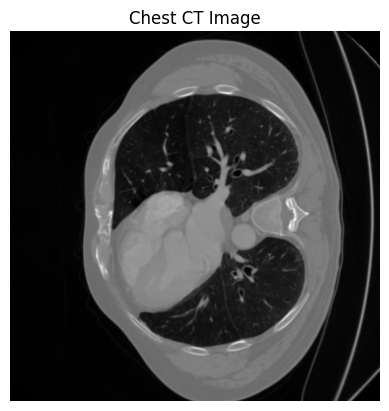

In [2]:
import matplotlib.pyplot as plt


def show_image(image_data: np.ndarray, title: str = "") -> None:
    plt.title(title)
    plt.imshow(image_data, cmap="gray")
    plt.axis("off")
    plt.show()


show_image(image, title="Chest CT Image")

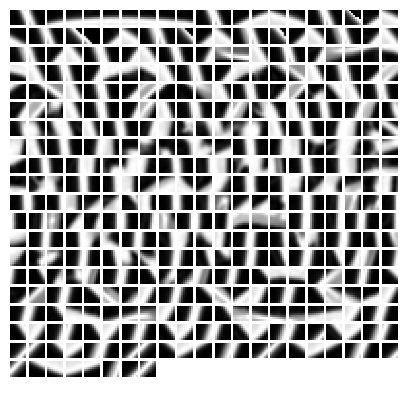

In [3]:
def get_patches(main_image: np.ndarray, var_thresh: float = 0.02, plot: bool = True,
                patch_size=(8, 8)) -> np.ndarray:
    image_patches = []
    i = 0
    while i <= main_image.shape[0] - patch_size[0]:
        j = 0
        while j <= main_image.shape[1] - patch_size[1]:
            patch = main_image[i:(i + patch_size[0]), j:(j + patch_size[1])]
            if np.var(patch) > var_thresh:
                image_patches.append(patch.flatten())
                j += patch_size[1]
            else:
                j += 1
        i += patch_size[0]

    if plot:
        grid_size = int(np.sqrt(len(image_patches))) + 1
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, ax in enumerate(axes.flat):
            if i < len(image_patches):
                patch = image_patches[i].reshape(patch_size)
                ax.imshow(patch, cmap="gray")
            ax.axis("off")
        plt.show()

    return np.array(image_patches)


patches = get_patches(image)

Iteration 0: Objective 2155.3441
Iteration 100: Objective 625.5519
Iteration 200: Objective 543.3407
Iteration 300: Objective 500.5809
Iteration 400: Objective 469.5335


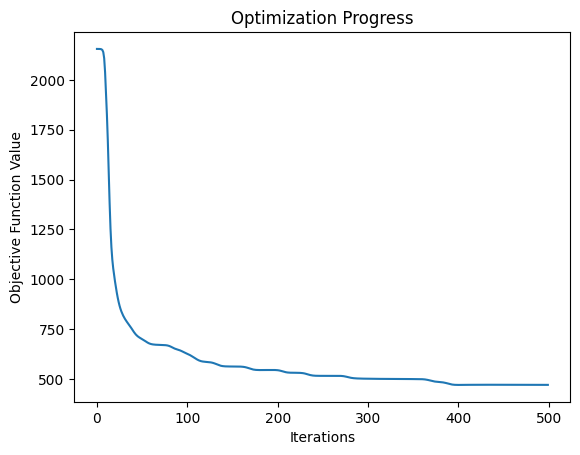

array([[-0.00821442, -0.00576029,  0.00258454, ...,  0.00687754,
         0.00386488,  0.02295245],
       [-0.01957794, -0.01951612,  0.01419666, ...,  0.04756704,
         0.00886997, -0.08089596],
       [-0.03790487, -0.04150205,  0.0329603 , ..., -0.14203948,
        -0.03052943,  0.10430718],
       ...,
       [-0.16235574, -0.1131946 ,  0.15496834, ...,  0.0373103 ,
         0.01634961,  0.02644113],
       [-0.20559199, -0.16818073,  0.20294306, ..., -0.01323599,
         0.0189694 , -0.02443263],
       [-0.23443212, -0.21092945,  0.23605633, ..., -0.00488014,
        -0.01228983,  0.00584721]], shape=(64, 64), dtype=float32)

In [4]:
def normalize_columns(d):
    """Normalize columns of D to have unit norm."""
    norms = np.linalg.norm(d, axis=0, keepdims=True)
    norms = np.maximum(norms, 1e-8)  # Prevent division by zero
    return d / norms


def objective_function(x, d, r, lambda_, p):
    """Compute the objective function value."""
    reconstruction_error = np.sum(np.linalg.norm(x.T - d @ r, ord=2, axis=0) ** 2)
    regularization = lambda_ * np.sum(np.linalg.norm(r, ord=p, axis=0) ** p)
    return reconstruction_error + regularization


def sparse_coding(x, d, lambda_, p=0.5, lr=0.001, n_iter=50):
    """Solve for r using p-norm regularization when p < 1."""
    n_samples, n_features = x.shape
    n_components = d.shape[1]
    r = np.zeros((n_components, n_samples))

    for _ in range(n_iter):
        gradient = -2 * d.T @ (x.T - d @ r)  # Gradient of reconstruction error

        # Avoid singularities in p-norm when p < 1
        sparsity_grad = lambda_ * p * np.sign(r) * np.maximum(np.abs(r), 1e-6) ** (p - 1)

        gradient += sparsity_grad

        r -= lr * gradient  # Gradient descent step

        # Optional: Clip large updates for stability
        r = np.clip(r, -10, 10)

    return r


def update_dictionary(d, x, r, learning_rate):
    """Gradient descent update for D."""
    gradient = np.zeros_like(d)
    for i in range(x.shape[0]):
        gradient += np.outer(x[i] - d @ r[:, i], r[:, i])

    d += learning_rate * gradient / np.linalg.norm(gradient)  # Normalize step size
    return normalize_columns(d)  # Ensure unit norm constraint


def dictionary_learning(x, p=1, n_components=64, lambda_=0.1, learning_rate=1, n_iter=500, plot=True):
    """Learn dictionary D using gradient descent and sparse coding."""
    n_samples, n_features = x.shape
    n_components = min(n_components, n_features)  # Ensure valid component count

    # Initialize dictionary using SVD
    v_t = np.linalg.svd(x, full_matrices=False)[2]
    d = normalize_columns(v_t.T[:, :n_components])

    objective_values = []

    for i in range(n_iter):
        r = sparse_coding(x, d, lambda_, p)

        obj_value = objective_function(x, d, r, lambda_, p)
        objective_values.append(obj_value)

        d = update_dictionary(d, x, r, learning_rate)

        if i % 100 == 0 and plot:
            print(f"Iteration {i}: Objective {obj_value:.4f}")

    if plot:
        plt.plot(range(n_iter), objective_values)
        plt.xlabel("Iterations")
        plt.ylabel("Objective Function Value")
        plt.title("Optimization Progress")
        plt.show()

    return d


dictionary_learning(patches)

Iteration 0: Objective 2127.5491
Iteration 100: Objective 179.2753
Iteration 200: Objective 155.1743
Iteration 300: Objective 155.1562
Iteration 400: Objective 155.1513


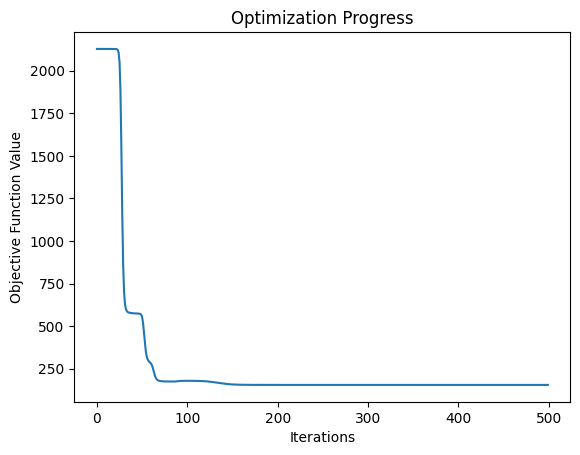

array([[ 0.02419895,  0.17402612, -0.18619959, ...,  0.21486656,
        -0.12641697,  0.06276362],
       [ 0.00286535,  0.14904797, -0.1128682 , ...,  0.17852098,
        -0.13957971,  0.04746747],
       [-0.02724254,  0.11088514, -0.01509156, ...,  0.14357986,
        -0.1689085 ,  0.03782763],
       ...,
       [-0.12776239, -0.15150785,  0.15968369, ...,  0.02798986,
         0.01770536,  0.19624372],
       [-0.02603057, -0.20782979,  0.06263278, ...,  0.04474534,
         0.01385965,  0.14723141],
       [ 0.06548652, -0.23883389, -0.03310246, ...,  0.08355919,
        -0.01754067,  0.10547657]], shape=(64, 64), dtype=float32)

In [5]:
dictionary_learning(patches, p=2)

Iteration 0: Objective 2132.2126
Iteration 100: Objective 172.8010
Iteration 200: Objective 172.4150
Iteration 300: Objective 171.8493
Iteration 400: Objective 171.4268


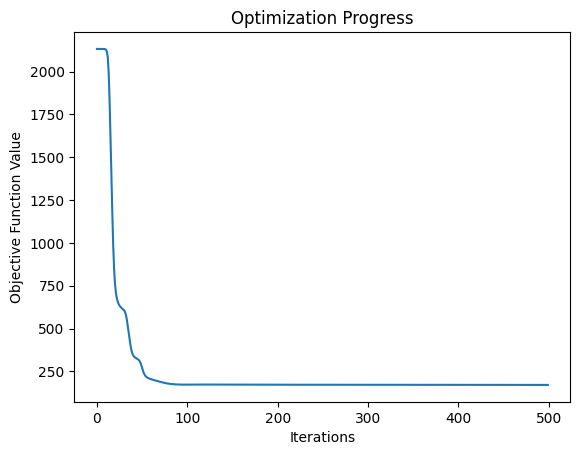

array([[-0.11277866,  0.10083526, -0.09911927, ...,  0.2104268 ,
        -0.03068476, -0.01663633],
       [-0.1073251 ,  0.08326643, -0.10566965, ...,  0.18165976,
        -0.07875697,  0.05229601],
       [-0.11163347,  0.05441933, -0.11084368, ...,  0.14431669,
        -0.14441064,  0.13711227],
       ...,
       [ 0.07802448, -0.08497356,  0.21975139, ..., -0.12343169,
         0.18260887, -0.14877294],
       [ 0.03254018, -0.16279024,  0.18357159, ..., -0.1673327 ,
         0.23891506, -0.1845715 ],
       [-0.02402342, -0.22089557,  0.13058315, ..., -0.18623406,
         0.2615892 , -0.19885673]], shape=(64, 64), dtype=float32)

In [6]:
dictionary_learning(patches, p=1.6)

Iteration 0: Objective 2143.8968
Iteration 100: Objective 361.1926
Iteration 200: Objective 315.8684
Iteration 300: Objective 308.2386
Iteration 400: Objective 291.1690


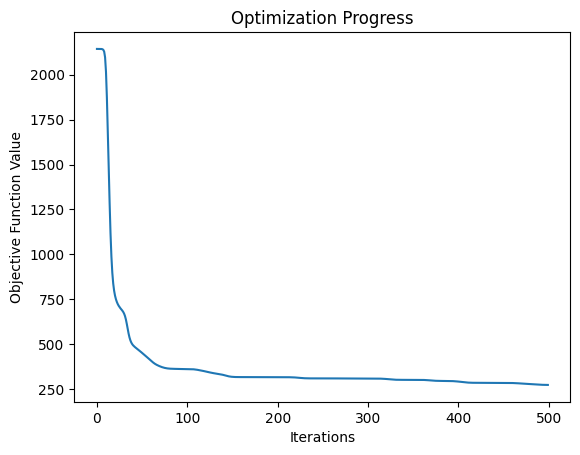

array([[-0.00510331, -0.0053615 , -0.04526283, ...,  0.0072809 ,
         0.00343152,  0.02295496],
       [-0.0153542 , -0.00319182, -0.04573693, ...,  0.04788626,
         0.00855248, -0.08068132],
       [-0.03267631, -0.00392743, -0.04346922, ..., -0.14208052,
        -0.03080689,  0.10451543],
       ...,
       [-0.12532063, -0.0595338 ,  0.2740535 , ...,  0.03728713,
         0.01612842,  0.02643506],
       [-0.18298212, -0.14451717,  0.27467903, ..., -0.01333243,
         0.0188462 , -0.02443101],
       [-0.22708817, -0.2179335 ,  0.25127536, ..., -0.00531051,
        -0.0122269 ,  0.00580009]], shape=(64, 64), dtype=float32)

In [7]:
dictionary_learning(patches, p=1.2)

Iteration 0: Objective 2163.5243
Iteration 100: Objective 748.2728
Iteration 200: Objective 689.2125
Iteration 300: Objective 624.0190
Iteration 400: Objective 570.6289


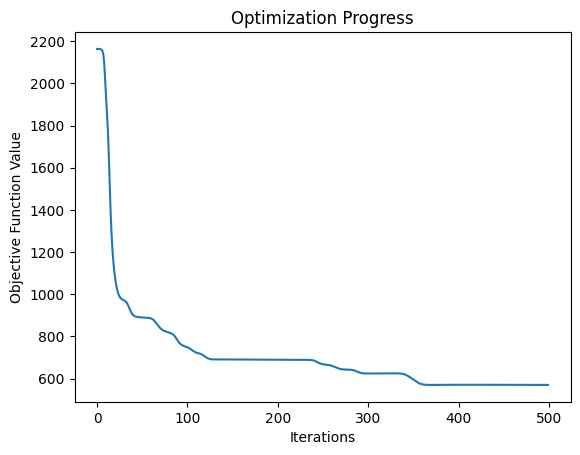

array([[-0.11464038,  0.00167955,  0.09795735, ...,  0.00717945,
         0.00353303,  0.023027  ],
       [-0.11066864, -0.00854955,  0.09657193, ...,  0.04772072,
         0.00859159, -0.08055616],
       [-0.1056134 , -0.02523519,  0.09551929, ..., -0.14225647,
        -0.03079201,  0.10463717],
       ...,
       [-0.13949575, -0.17497648,  0.1483754 , ...,  0.0373165 ,
         0.01595938,  0.02648498],
       [-0.1467024 , -0.21992996,  0.16197711, ..., -0.01324394,
         0.01878983, -0.02432922],
       [-0.14968523, -0.2484543 ,  0.16935752, ..., -0.00517954,
        -0.01216344,  0.00593475]], shape=(64, 64), dtype=float32)

In [8]:
dictionary_learning(patches, p=0.8)

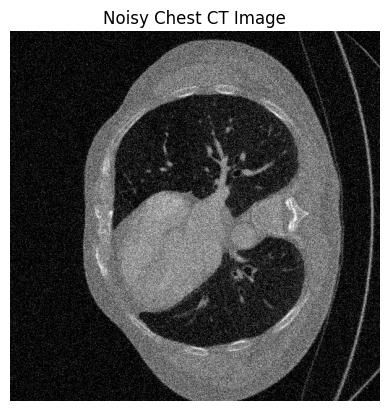

In [9]:
def add_gaussian_noise(main_image, std_ratio=0.1):
    noise_std = std_ratio * (main_image.max() - main_image.min())
    noisy_image = main_image + np.random.normal(0, noise_std, main_image.shape)
    return np.clip(noisy_image, 0, 1)


noisy = add_gaussian_noise(image)
show_image(noisy, title="Noisy Chest CT Image")

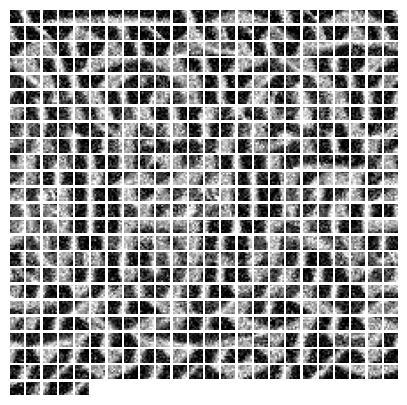

array([[-0.20068541,  0.20391022, -0.17882235, ..., -0.14181675,
        -0.15297837, -0.16763778],
       [-0.17309672,  0.18180779, -0.15312474, ..., -0.12555583,
        -0.11394638, -0.12521333],
       [-0.14532332,  0.14427715, -0.08442152, ..., -0.10486329,
        -0.06458418, -0.05827065],
       ...,
       [ 0.12557513, -0.23865933,  0.21500537, ..., -0.02836356,
        -0.13630687, -0.12915989],
       [ 0.18954636, -0.25003834,  0.14684214, ..., -0.09195636,
        -0.11813695, -0.15959442],
       [ 0.25054509, -0.25634709,  0.06764171, ..., -0.15506013,
        -0.10600239, -0.1987783 ]], shape=(64, 64))

In [10]:
def rrmse(original_img: np.ndarray, noisy_img: np.ndarray) -> float:
    return np.sqrt(np.sum((original_img - noisy_img) ** 2) / np.sum(original_img ** 2))

noisy_patches = get_patches(noisy)
noise_dict = dictionary_learning(noisy_patches, p=2, plot=False)
noise_dict

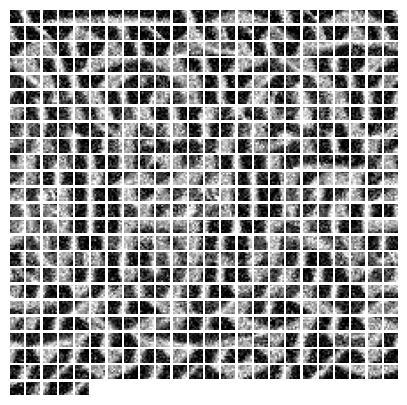

array([[0.        , 0.04995064, 0.05091611, ..., 0.21008512, 0.478482  ,
        0.58375992],
       [0.        , 0.07030236, 0.        , ..., 0.19920598, 0.36696072,
        0.51495205],
       [0.        , 0.        , 0.16311095, ..., 0.15495031, 0.2023314 ,
        0.5970798 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(512, 512))

In [11]:
def denoise_image(noisy_image, noise_patches_dict, p=2):
    noisy_img_patches = get_patches(noisy_image)
    denoised_patches = []

    for patch in noisy_img_patches:
        patch = patch.reshape(-1, 1)  # Reshape patch to 2D
        r = sparse_coding(patch, noise_patches_dict, lambda_=0.1, p=p, n_iter=50)
        denoised_patch = noise_patches_dict @ r
        denoised_patches.append(denoised_patch.flatten())  # Flatten the denoised patch

    denoised_image = np.zeros_like(noisy_image)
    i = 0
    patch_size = 8
    for j in range(0, noisy_image.shape[0] - patch_size + 1, patch_size):
        for k in range(0, noisy_image.shape[1] - patch_size + 1, patch_size):
            if i < len(denoised_patches):
                denoised_image[j:(j + patch_size), k:(k + patch_size)] = denoised_patches[i][:patch_size * patch_size].reshape(patch_size, patch_size)
                i += 1
            else:
                break

    return denoised_image

denoised_img = denoise_image(noisy, noise_dict)
denoised_img